In [43]:
import pandas as pd
import requests
import numpy as np
# Don't forget to 'pip install fastf1'
import fastf1 as ff1
from fastf1 import plotting

# Don't forget to 'pip install seaborn'
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [21]:
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()

    return response['MRData']

In [13]:
# By changing these params you can easily get other seasons
season = 2023
drivers_to_exclude = ['']

In [31]:
all_quali_results = pd.DataFrame()

# We want this so that we know which driver belongs to which team, so we can color them later
team_drivers = {}

current_round = 1

while True:
    race = ergast_retrieve(f'{season}/{current_round}/qualifying')

    # If session doesn't exist, cancel loop
    if not race['RaceTable']['Races']:
        break

    results = race['RaceTable']['Races'][0]['QualifyingResults']

    quali_results = {'round': current_round}

    for j in range(len(results)):
        driver = results[j]['Driver']['code']
        position = int(results[j]['position'])
        team = results[j]['Constructor']['name']

        if driver in drivers_to_exclude:
            continue

        # Create mapping for driver - team
        if not team in team_drivers:
            team_drivers[team] = [driver]
        else:
            if not driver in team_drivers[team]:
                team_drivers[team].append(driver)

        quali_results[driver] = position

    all_quali_results = all_quali_results.append(quali_results, ignore_index=True)

    current_round += 1

C:\Users\getou\AppData\Local\Temp\ipykernel_26540\3946753996.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_quali_results = all_quali_results.append(quali_results, ignore_index=True)
C:\Users\getou\AppData\Local\Temp\ipykernel_26540\3946753996.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_quali_results = all_quali_results.append(quali_results, ignore_index=True)
C:\Users\getou\AppData\Local\Temp\ipykernel_26540\3946753996.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_quali_results = all_quali_results.append(quali_results, ignore_index=True)
C:\Users\getou\AppData\Local\Temp\ipykernel_26540\3946753996.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [32]:
# Now we want to know, per round, per team, who qualified higher?
all_quali_battle_results = []
team_colors_palette = []

for team in team_drivers:
    drivers = team_drivers[team]

    quali_results = all_quali_results[drivers]

    # We do dropna() to only include the sessions in which both drivers participated
    fastest_driver_per_round = quali_results.dropna().idxmin(axis=1)

    quali_battle_result = fastest_driver_per_round.value_counts().reset_index()

    for _, driver in quali_battle_result.iterrows():
        all_quali_battle_results.append({
            'driver': driver['index'],
            'team': team,
            'quali_score': driver[0]
        })

    team_colors_palette.append(ff1.plotting.team_color(team))
    # If none, replace None with grey
    team_colors_palette = ['#D3D3D3' if v is None else v for v in team_colors_palette]


# Finally, convert to a DataFrame so we can plot
all_quali_battle_results = pd.DataFrame.from_dict(all_quali_battle_results)

In [75]:
plot_width = 11.7
plot_height = 8.27
plot_size = [plot_width, plot_height]
title_font_size = int(2 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
autolayout = True
plot_title = f"{season} Teammate Qualifying Battle"
plot_file = f"{season} Teammate Qualifying Battle"
plot_ratios = [7,7]
plot_filename = plot_file.replace(" ", "") + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)
def add_logo():
    # Define the new width and height for the logo
    new_width = 35
    new_height = 35
    # Resize the logo
    logo_resized = logo_img.resize((new_width, new_height))
    logo_resized_np = np.array(logo_resized)
    logo_x = 444
    logo_y = 290
    fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

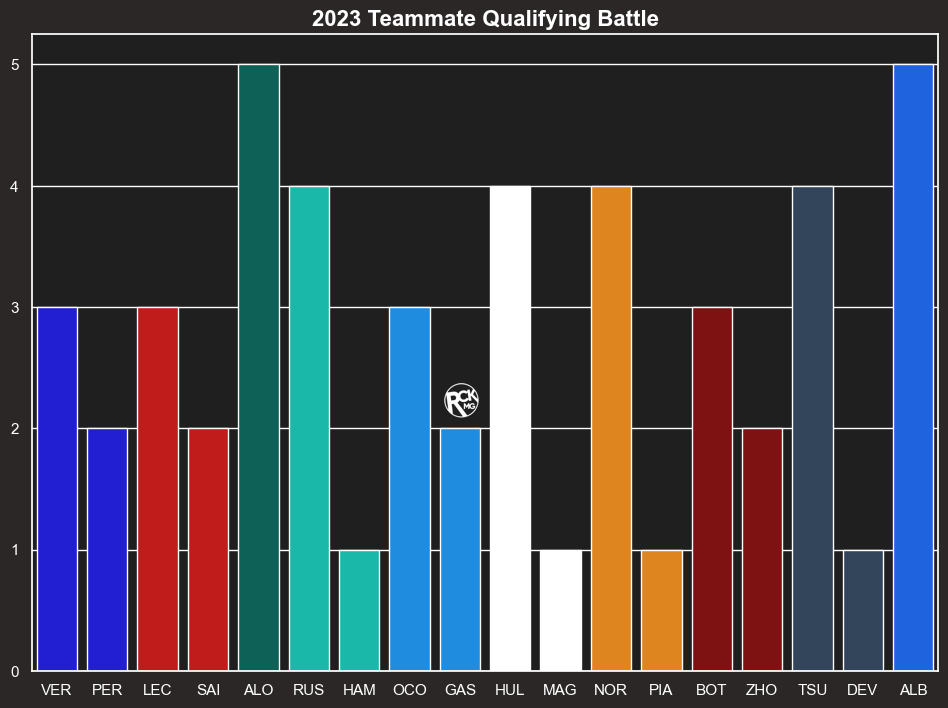

In [94]:
# Set the background color to black and text color to white
sns.set(rc={'figure.figsize':plot_size, 'axes.facecolor': '#2b2727', 'figure.facecolor': '#2b2727', 'text.color': 'white'})

# Create custom color palette
custom_palette = sns.set_palette(sns.color_palette(team_colors_palette))

fig, ax = plt.subplots()

ax.set_title(plot_title, color='white', size=title_font_size, fontweight='bold')

g = sns.barplot(
    x='driver',
    y='quali_score',
    hue='team',
    data=all_quali_battle_results,
    dodge=False,
    palette=custom_palette,
)

plt.yticks(range(max(all_quali_battle_results['quali_score']) + 1))

plt.legend([],[], frameon=False)

g.set(xlabel=None)
g.set(ylabel=None)

# Set the facecolor of the axis to black
ax.set_facecolor('#1f1f1f')

# Set the x and y axis label colors to white
g.xaxis.label.set_color('white')
g.yaxis.label.set_color('white')

# Set tick colors to white
g.tick_params(colors='white')
add_logo()
#plt.savefig('img/qualifying_battles.png')
plt.show()